# Draft 1 - Figure 2

_Description of our goal:_  

a. Cone plots in select regions with obs. unc. to ICV unc. ratio, b. trends zeroed to ToE, and maybe c. evolution of obs. Unc.

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
import matplotlib.patheffects as pe

import copy

%matplotlib inline

In [2]:
def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.75, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

In [4]:
def create_coneplot(
    obs_percentiles: xr.DataArray,
    model_percentiles: xr.DataArray,
    obs_times: xr.DataArray,
    model_times: xr.DataArray,
    mean_tte: xr.DataArray,
    strict_tte: xr.DataArray,
    uncertainty_ratio: xr.DataArray=None,
    startyear: int=1900,
    title: str=None,
    ylim: tuple=None,
):

    fig,ax = plt.subplots(1,1,figsize=(6, 6))
    
    if (strict_tte == 2020): strict_tte = np.nan
    
    ax.fill_between(
        obs_times,
        obs_percentiles.sel(percentile=0.025),
        obs_percentiles.sel(percentile=0.975),
        color='blue',
        alpha=0.5,
        label=str(mean_tte.obs.values),
    )
    
    ax.fill_between(
        model_times,
        model_percentiles.sel(percentile=0.025),
        model_percentiles.sel(percentile=0.975),
        color='black',
        alpha=0.5,
        label=str(mean_tte.model.values),
    )
    
    ax.plot(
        obs_times,
        obs_percentiles.sel(percentile=0.50),
        color='blue'
    )
    
    ax.tick_params(axis='both', labelsize=18)
    
    ax.set_xlim(startyear, 2020)
    if ylim is not None:
        ax.set_ylim(ylim)      

    if np.isnan(strict_tte) and np.isnan(mean_tte):
        title_p2 = 'Median ToE: None, Strict ToE: None'
    elif np.isnan(strict_tte):
        title_p2 = 'Median ToE: %d, Strict ToE: None' % (mean_tte)
    else:
        title_p2 = 'Median ToE: %d, Strict ToE: %d' % (mean_tte, strict_tte)
    
    if title is not None:
        ax.set_title(f"{title} \n {title_p2}", fontsize=18)
    else:
        ax.set_title(f"{title_p2}", fontsize=18)
    ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=18)
    
    if uncertainty_ratio is not None:
        # Set up another y-axis on the right side of the plot
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        
        color = 'tab:red'
        ax2.plot(
            startyear + uncertainty_ratio.duration - 1,
            uncertainty_ratio,
            color=color,
            alpha=0.9,
        )
        ax2.set_ylim([0,3])
        ax2.tick_params(axis='y', labelcolor=color,labelsize=18)  
        ax2.set_ylabel('Uncertainty Ratio', color=color,fontsize=18)
        axs2.append(ax2)

    return fig

## Load computed ToE data

In [5]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [6]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/xagg/'
mpi_dir         = 'MPI-GE/xagg/'
canesm2_dir     = 'CanESM2/xagg/'
esm2m_dir       = 'ESM2M/xagg/'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [7]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [8]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [9]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)
cesm1_pic_spatial_trends_all["percentile"] = [0.025, 0.975]

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)
mpi_pic_spatial_trends_all["percentile"] = [0.025, 0.975]

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)
canesm2_pic_spatial_trends_all["percentile"] = [0.025, 0.975]

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)
esm2m_pic_spatial_trends_all["percentile"] = [0.025, 0.975]


In [10]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath)

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath)

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath)

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath)

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [11]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/xagg_correctedtime/'
hadcrut5_dir    = 'HadCRUT5/20240820/xagg/'
obsle_dir       = 'mckinnon_OLENS/'

In [12]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
obsle_tas_var    = 'tas'

In [13]:
obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [14]:
obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Also load trend percentiles for cone plots

In [15]:
gistemp_5x5_spatial_trendpercs_filepath  = glob.glob('%s/%s/*movingstartdate.Percentiles.5x5*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_spatial_trendpercs_filepath     = glob.glob('%s/%s/*movingstartdate.Percentiles.5x5*.nc' % (obs_tseries_dir,hadcrut5_dir))

In [16]:
gistemp_regional_trendpercs_filepath  = glob.glob('%s/%s/*movingstartdate.Percentiles.IPCCRegions*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_trendpercs_filepath = glob.glob('%s/%s/*movingstartdate.Percentiles.IPCCRegions*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load start years as well

In [17]:
gistemp_spatial_startyears_filepath = glob.glob('%s/%s/*startyears.5x5*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_spatial_startyears_filepath = glob.glob('%s/%s/*startyears.5x5*.nc' % (obs_tseries_dir,hadcrut5_dir))

gistemp_regional_startyears_filepath  = glob.glob('%s/%s/*startyears.IPCCRegions*.nc' % (obs_tseries_dir,gistemp_5x5_dir))
hadcrut5_regional_startyears_filepath = glob.glob('%s/%s/*startyears.IPCCRegions*.nc' % (obs_tseries_dir,hadcrut5_dir))

Load obs-le percentile data

In [18]:
gistemp_5x5_spatial_trendpercs_all  = xr.open_dataarray(*gistemp_5x5_spatial_trendpercs_filepath).drop('startyear').squeeze()
hadcrut5_spatial_trendpercs_all     = xr.open_dataarray(*hadcrut5_spatial_trendpercs_filepath).drop('startyear').squeeze()

/glade/derecho/scratch/jonahshaw/tmp/ipykernel_49455/3296986370.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  gistemp_5x5_spatial_trendpercs_all  = xr.open_dataarray(*gistemp_5x5_spatial_trendpercs_filepath).drop('startyear').squeeze()
/glade/derecho/scratch/jonahshaw/tmp/ipykernel_49455/3296986370.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hadcrut5_spatial_trendpercs_all     = xr.open_dataarray(*hadcrut5_spatial_trendpercs_filepath).drop('startyear').squeeze()


In [19]:
gistemp_regional_trendpercs_all  = xr.open_dataarray(*gistemp_regional_trendpercs_filepath)
hadcrut5_regional_trendpercs_all     = xr.open_dataarray(*hadcrut5_regional_trendpercs_filepath)

In [20]:
gistemp_spatial_startyears = xr.open_dataarray(*gistemp_spatial_startyears_filepath)
hadcrut5_spatial_startyears = xr.open_dataarray(*hadcrut5_spatial_startyears_filepath)

gistemp_regional_startyears = xr.open_dataarray(*gistemp_regional_startyears_filepath)
hadcrut5_regional_startyears = xr.open_dataarray(*hadcrut5_regional_startyears_filepath)

In [21]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_spatial_startyears = process_startyears(
    gistemp_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_spatial_startyears = process_startyears(
    hadcrut5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_startyears = process_startyears(
    gistemp_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_regional_startyears = process_startyears(
    hadcrut5_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

### Collate data for easy access

In [22]:
# obs_spatial_trend_dict  = {'GISTEMP_5x5':gistemp_5x5_spatial_trends_masked,
#                            'HadCRUT':hadcrut5_spatial_trends_masked}
# obs_regional_trend_dict = {'GISTEMP_5x5':gistemp_regional_trends_all,
#                            'HadCRUT':hadcrut5_regional_trends_all}
# obs_trend_dict          = {'spatial':obs_spatial_trend_dict,
#                            'regional':obs_regional_trend_dict}
obs_spatial_perc_dict = {
    "GISTEMP_5x5":gistemp_5x5_spatial_trendpercs_all,
    "HadCRUT":hadcrut5_spatial_trendpercs_all,
}
obs_regional_perc_dict = {
    "GISTEMP_5x5":gistemp_regional_trendpercs_all,
    "HadCRUT":hadcrut5_regional_trendpercs_all,
}
obs_perc_dict = {
    "spatial":obs_spatial_perc_dict,
    "regional":obs_regional_perc_dict,
}

obs_spatial_startyear_dict = {
    "GISTEMP_5x5": gistemp_spatial_startyears,
    "HadCRUT": hadcrut5_spatial_startyears,
}
obs_regional_startyear_dict = {
    "GISTEMP_5x5": gistemp_regional_startyears,
    "HadCRUT": hadcrut5_regional_startyears,
}
obs_startyear_dict = {
    "spatial": obs_spatial_startyear_dict,
    "regional": obs_regional_startyear_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute uncertainty ratio

In [23]:
cesm1_pic_95confspread   = cesm1_pic_regional_trends_all.sel(percentile=0.975) - cesm1_pic_regional_trends_all.sel(percentile=0.025)
gistemp_reg_95confspread = gistemp_regional_trendpercs_all.sel(percentile=0.975) - gistemp_regional_trendpercs_all.sel(percentile=0.025)

gistemp_cesm1_uncratio = gistemp_reg_95confspread / cesm1_pic_95confspread

In [24]:
gistemp_5x5_trends_50perc_reindex = gistemp_regional_trendpercs_all.sel(percentile=0.5).copy()
regional_tte_data = regional_masked_da

mean_tte  = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='mean')
strict_tte = regional_tte_data.sel(model='CESM1',obs='GISTEMP_5x5',metric='strict')

startyear = 1900

reindexed_trends = []
for region_index in gistemp_5x5_trends_50perc_reindex.RegionIndex:

    region_trends = gistemp_5x5_trends_50perc_reindex.sel(RegionIndex=region_index)
    region_mean_tte = mean_tte.sel(RegionIndex=region_index)
    
    region_trends['years_since_emerge'] = startyear + region_trends.duration - 1 - region_mean_tte
    
    reindexed_trends.append(region_trends)    

reindexed_trends_concat = xr.concat(reindexed_trends,dim='RegionIndex')

In [25]:
# Compute delays for all regions.
mean_delay_trends = []

for delay in range(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max())):
    
    delay_mean_value = reindexed_trends_concat.where(reindexed_trends_concat.years_since_emerge==delay).mean()
    
    mean_delay_trends.append(delay_mean_value.values)

delay_range = np.arange(int(reindexed_trends_concat.years_since_emerge.min()),int(reindexed_trends_concat.years_since_emerge.max()))

delay_da = xr.DataArray(
    data=mean_delay_trends,
    dims=["delay",],
    coords={'delay':delay_range}
)

Text(-0.05, 1.08, 'f.')

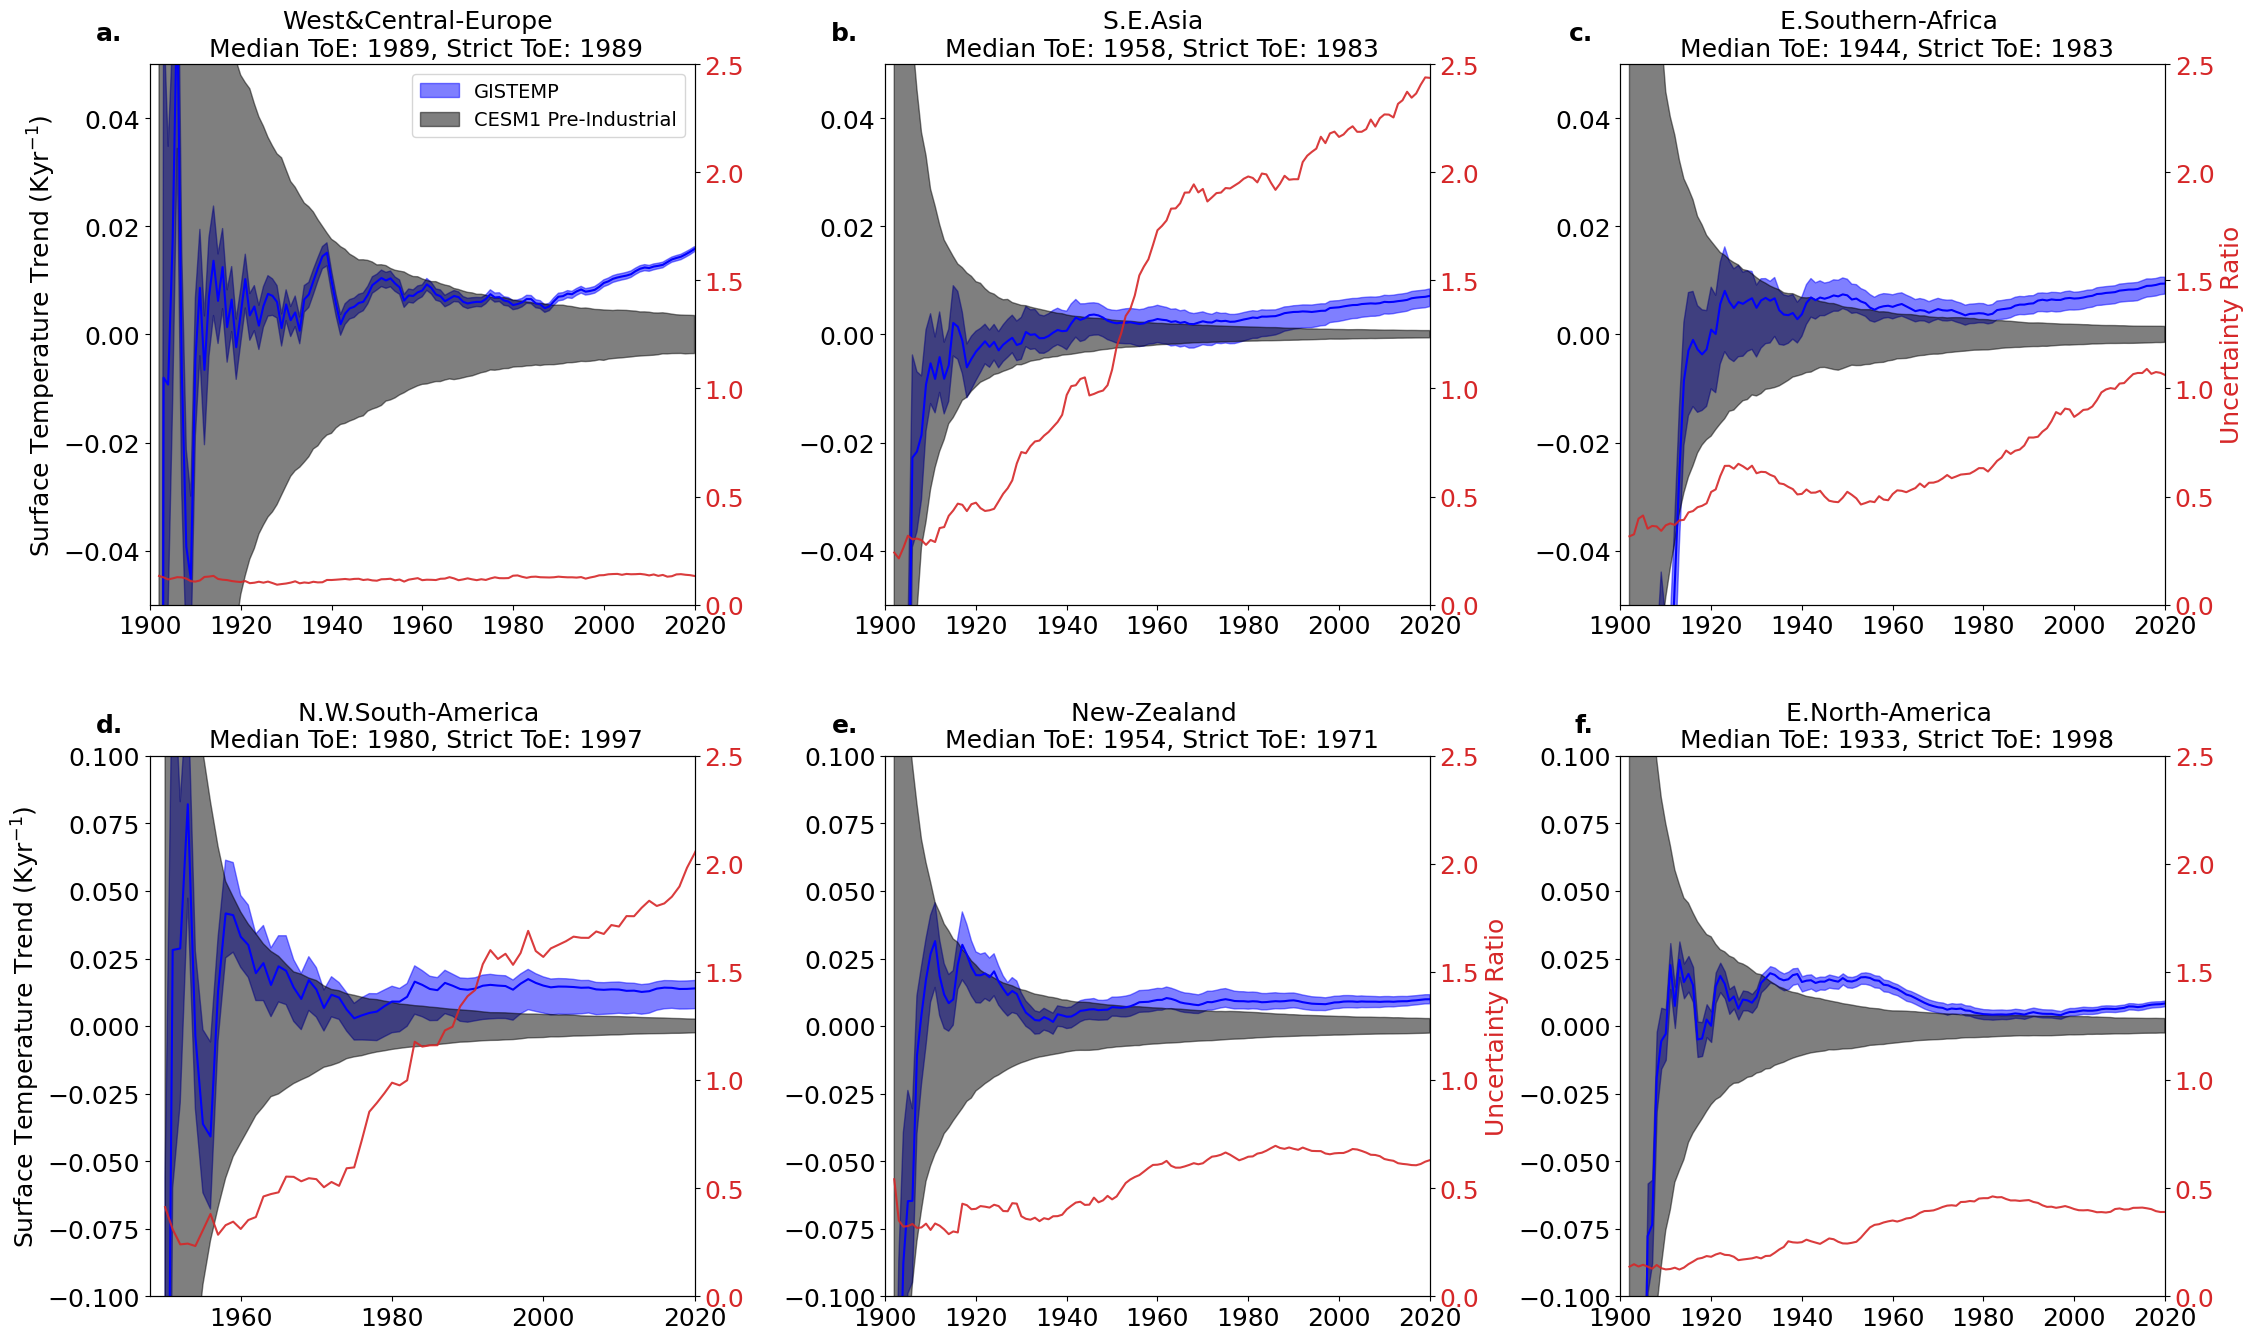

In [28]:
fig,axs = plt.subplots(2,3,figsize=(26,16))
axs = axs.flat

fig.subplots_adjust(hspace=0.28,wspace=0.35)

# Set values here:
# 5: SE North America
# 9: N.W. S. America
# 13: SW S. America
# 17: West&Central-Europe
# 42: S. Australia
# 43: New-Zealand
# 23: N. Eastern-Africa 
# 24: S.Eastern-Africa
# 26: E.Southern-Africa
# 33: E. Central Asia
# 34: Tibetan Plateau (small delay)
# 38: S.E. Asia
# region_indices = [5, 38, 26, 17, 9, 33] # Good but has Asia twice
region_indices = [17, 38, 26, 9, 43, 5] # Adds New Zealand
region_ylims   = [[-0.05,0.05],[-0.05,0.05],[-0.05,0.05],[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],]
# startyear = 1900

obs_percentile_data   = gistemp_regional_trendpercs_all
obs_startyear_data    = gistemp_regional_startyears
model_percentile_data = cesm1_pic_regional_trends_all

fontsize = 18

# year_gistemp = startyear + obs_percentile_data.duration - 1
# year_cesm1   = startyear + model_percentile_data.duration - 1

axs2 = []

for region_index,ylim,ax in zip(region_indices,region_ylims,axs):

    startyear = obs_startyear_data.sel(RegionIndex=region_index)
    year_gistemp = startyear + obs_percentile_data.duration - 1
    year_cesm1   = startyear + model_percentile_data.duration - 1

    # Compute the mean and strict ToEs
    _mean_tte        = mean_tte.sel(RegionIndex=region_index)
    _strict_tte      = strict_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    
    if (_strict_tte == 2020): _strict_tte = np.nan #xr.where(part_undef_gistemp,2020 - mean_tte_gistemp,np.nan)

    ax.fill_between(year_gistemp,
                    obs_percentile_data.sel(percentile=0.025,RegionIndex=region_index),
                    obs_percentile_data.sel(percentile=0.975,RegionIndex=region_index),
                    color='blue',
                    alpha=0.5,
                    label='GISTEMP',
                   )

    ax.fill_between(year_cesm1,
                    model_percentile_data.sel(percentile=0.025,RegionIndex=region_index),
                    model_percentile_data.sel(percentile=0.975,RegionIndex=region_index),
                    # cesm1_pic_trends_97_5perc.sel(RegionIndex=region_index),
                    color='black',
                    alpha=0.5,
                    label='CESM1 Pre-Industrial',
                   )

    ax.plot(year_gistemp,
            obs_percentile_data.sel(percentile=0.50,RegionIndex=region_index),
            color='blue'
           )

    ax.tick_params(axis='both', labelsize=18)

    # ax.set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=fontsize)
    # ax.set_xlabel('Year',fontsize=fontsize)

    ax.set_xlim(startyear, 2020)
    # ax.set_xlim(1963,2020)
    ax.set_ylim(ylim)
    
    # Set up another y-axis on the right side of the plot
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    # ax2.set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)  # we already handled the x-label with ax1
    ax2.plot(
        startyear + gistemp_cesm1_uncratio.duration - 1,
        _gistemp_cesm1_uncratio,
        color=color,
        alpha=0.9,
    )#,linestyle='dashed')
    ax2.set_ylim([0,2.5])
    ax2.tick_params(axis='y', labelcolor=color,labelsize=18)        

    title_p1 = str(obs_percentile_data.sel(RegionIndex=region_index).RegionName.values)

    if np.isnan(_strict_tte) and np.isnan(_mean_tte):
        title_p2 = 'Median ToE: None, Strict ToE: None'
    elif np.isnan(_strict_tte):
        title_p2 = 'Median ToE: %d, Strict ToE: None' % (_mean_tte)
    else:
        title_p2 = 'Median ToE: %d, Strict ToE: %d' % (_mean_tte, _strict_tte)
    
    # if np.isnan(_strict_tte):
    #     title_p2 = 'Mean ToE: %d, Strict ToE: None' % (_mean_tte)
    # else:
    #     title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (_mean_tte,_strict_tte)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (_mean_tte.values,_strict_tte.values)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %d' % (mean_tte,strict_tte)
    # title_p2 = 'Mean ToE: %d, Strict ToE: %s' % (mean_tte,str(np.round(strict_tte.values,0)))

    ax.set_title('%s \n %s' % (title_p1,title_p2),fontsize=fontsize)
    
    axs2.append(ax2)

axs[0].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=fontsize)
axs[3].set_ylabel('Surface Temperature Trend (Kyr$^{-1}$)',fontsize=fontsize)

axs2[2].set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)
axs2[4].set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)
# axs2[5].set_ylabel('Uncertainty Ratio', color=color,fontsize=fontsize)

axs[0].legend(fontsize=fontsize-4)

# Add subplot labels
axs[0].text(-0.05, 1.08, 'a.', transform=axs[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[1].text(-0.05, 1.08, 'b.', transform=axs[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[2].text(-0.05, 1.08, 'c.', transform=axs[2].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[3].text(-0.05, 1.08, 'd.', transform=axs[3].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[4].text(-0.05, 1.08, 'e.', transform=axs[4].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
axs[5].text(-0.05, 1.08, 'f.', transform=axs[5].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

In [29]:
to_png(file=fig,filename='draft4_fig2_cones',dpi=300,ext='pdf',bbox_inches='tight') # or .pdf 

Create coneplot for lat-lon locations.  
Example: Super early emergence in the Atlantic around -7 deg. lat, -18 deg. lon

In [77]:
cesm1_5x5_95confspread   = cesm1_pic_spatial_trends_all.sel(percentile=0.975) - cesm1_pic_spatial_trends_all.sel(percentile=0.025)
gistemp_5x5_95confspread = gistemp_5x5_spatial_trendpercs_all.sel(percentile=0.975) - gistemp_5x5_spatial_trendpercs_all.sel(percentile=0.025)

gistemp_cesm1_5x5_uncratio = gistemp_5x5_95confspread / cesm1_5x5_95confspread

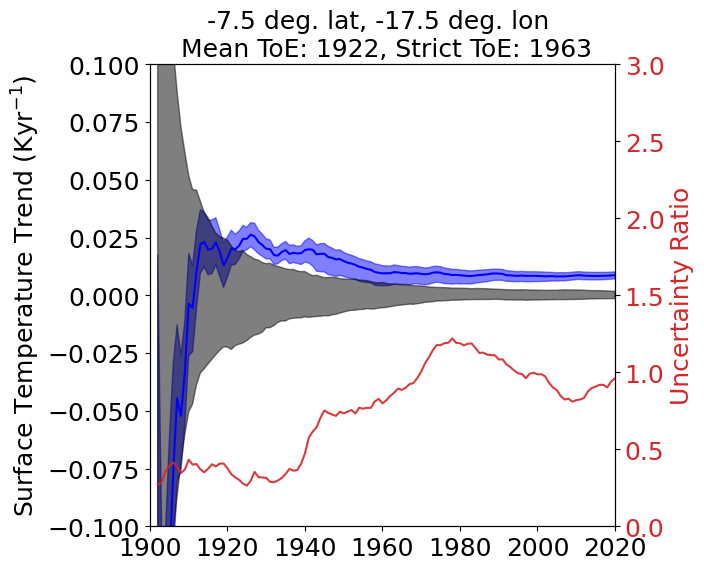

In [78]:
# startyear = 1900
model="ESM2M"
obs="GISTEMP_5x5"

target_lat = -7 #55
target_lon = -18 #-31

startyear = obs_spatial_startyear_dict[obs].sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)

obs_95conf = obs_spatial_perc_dict[obs].sel(percentile=0.975) - obs_spatial_perc_dict[obs].sel(percentile=0.025)
model_95conf = model_spatial_trend_dict[model].sel(percentile=0.975) - model_spatial_trend_dict[model].sel(percentile=0.025)
uncertainty_ratio = obs_95conf / model_95conf

obs_percentile_data   = obs_spatial_perc_dict[obs] #gistemp_regional_trendpercs_all # hadcrut5_regional_trendpercs_all
model_percentile_data = model_spatial_trend_dict[model]

year_gistemp = startyear + obs_percentile_data.duration - 1
year_cesm1   = startyear + model_percentile_data.duration - 1

mean_tte_spatial = spatial_masked_da.sel(
    metric="mean",
    model=model,
    obs=obs,
)
strict_tte_spatial = spatial_masked_da.sel(
    metric="strict",
    model=model,
    obs=obs,
)

# Compute the mean and strict ToEs
_mean_tte = mean_tte_spatial.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_strict_tte = strict_tte_spatial.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_uncratio = uncertainty_ratio.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_obs_percentile_data = obs_percentile_data.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)
_model_percentile_data = model_percentile_data.sel(
    lat=target_lat,
    lon=target_lon,
    method="nearest",
)

fig = create_coneplot(
    obs_percentiles=_obs_percentile_data,
    model_percentiles=_model_percentile_data,
    obs_times=year_gistemp,
    model_times=year_cesm1,
    mean_tte=_mean_tte,
    strict_tte=_strict_tte,
    uncertainty_ratio=_uncratio,
    ylim=[-0.1, 0.1],
    title=f"{_mean_tte.lat.values} deg. lat, {_mean_tte.lon.values} deg. lon",
)

Create coneplots for all IPCC regions:

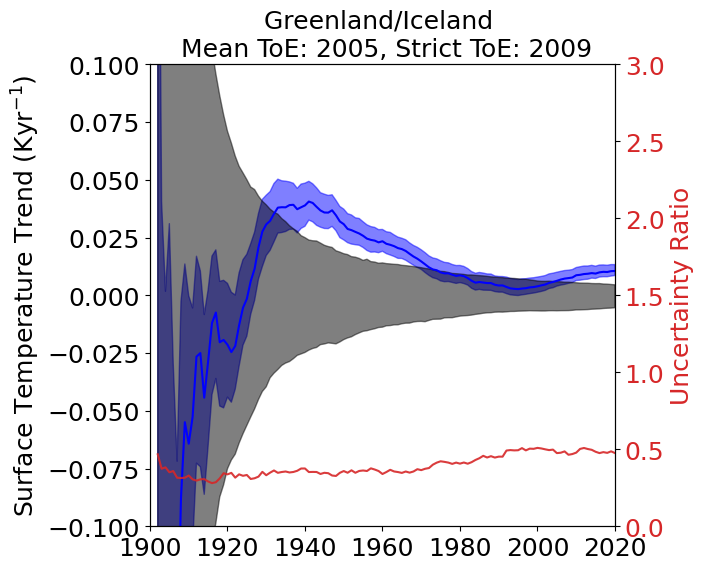

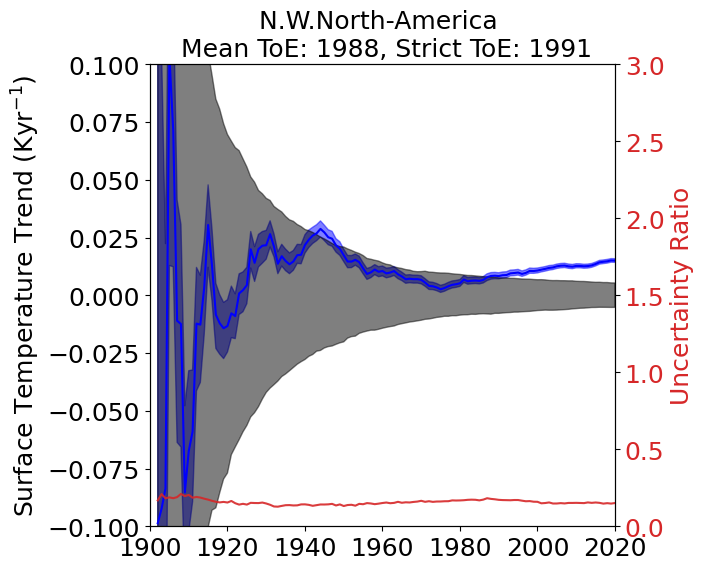

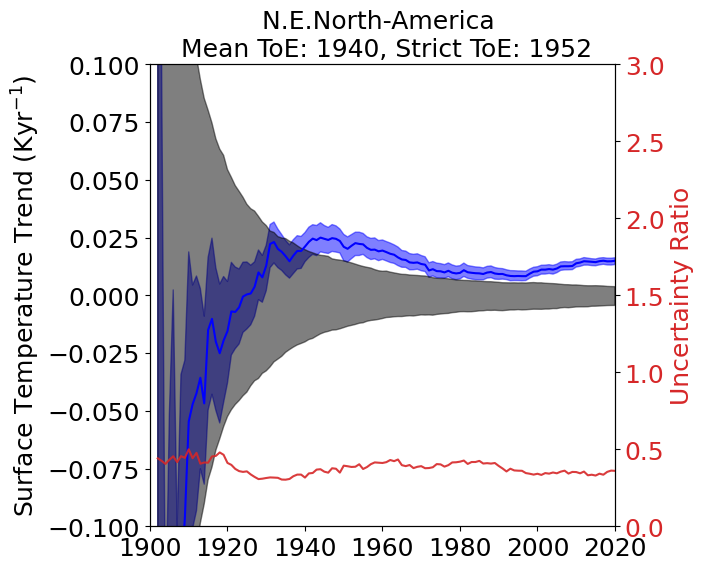

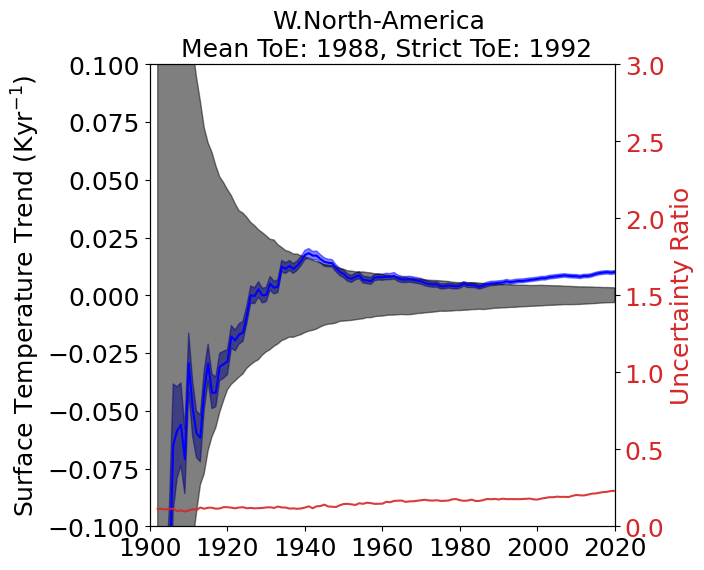

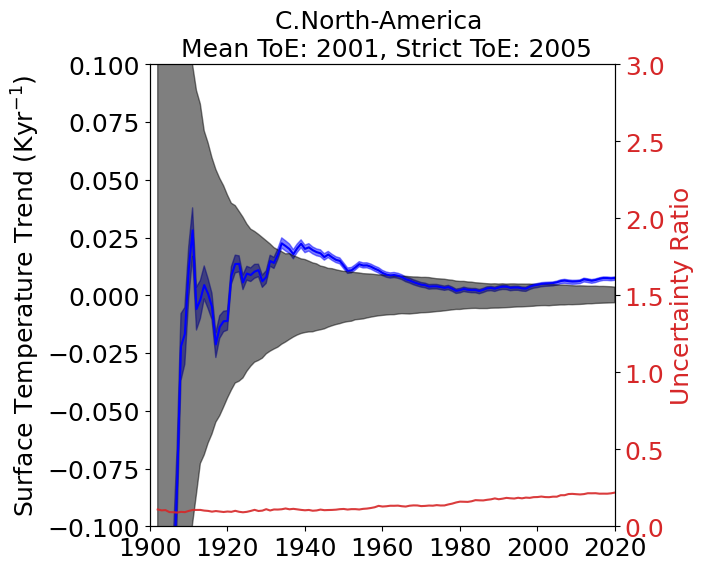

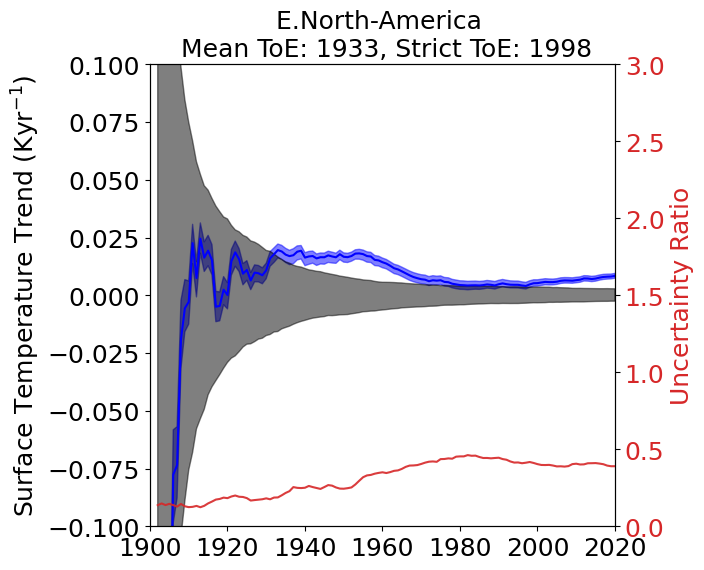

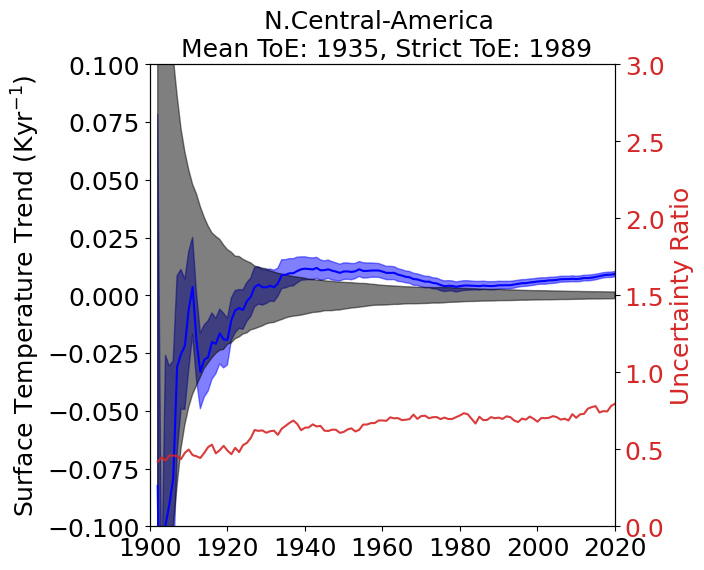

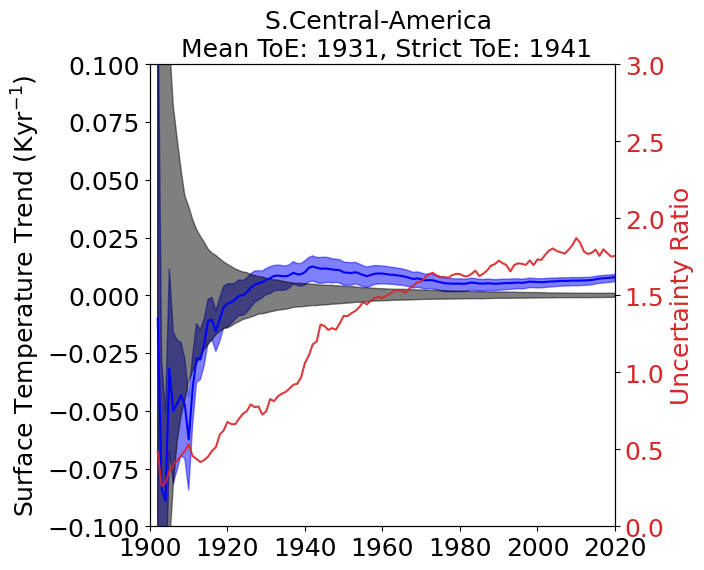

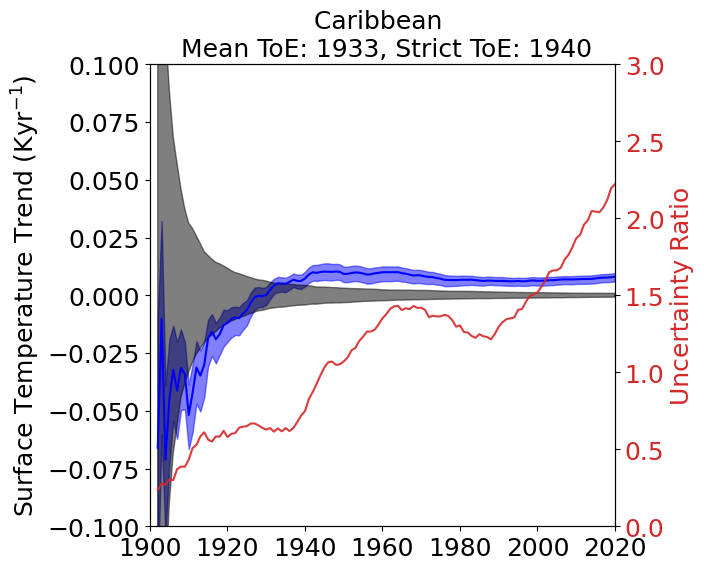

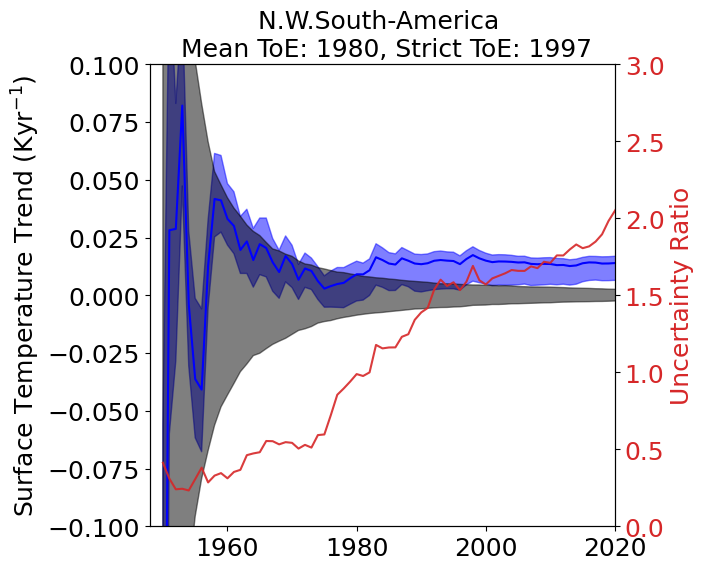

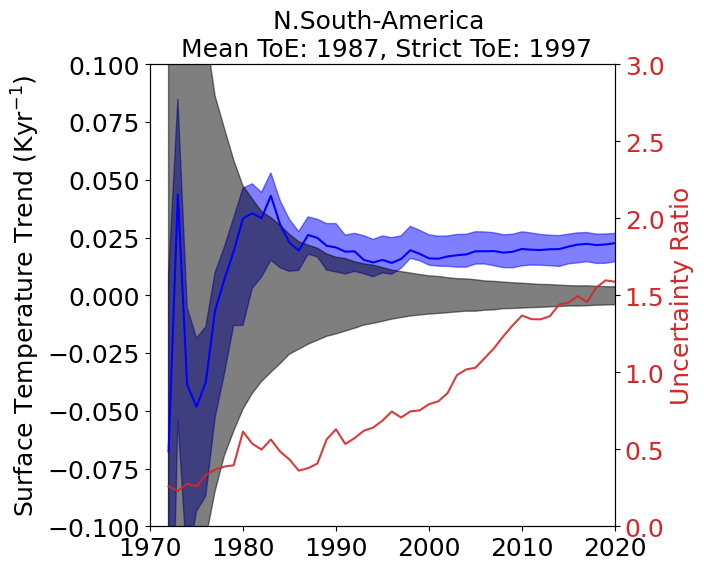

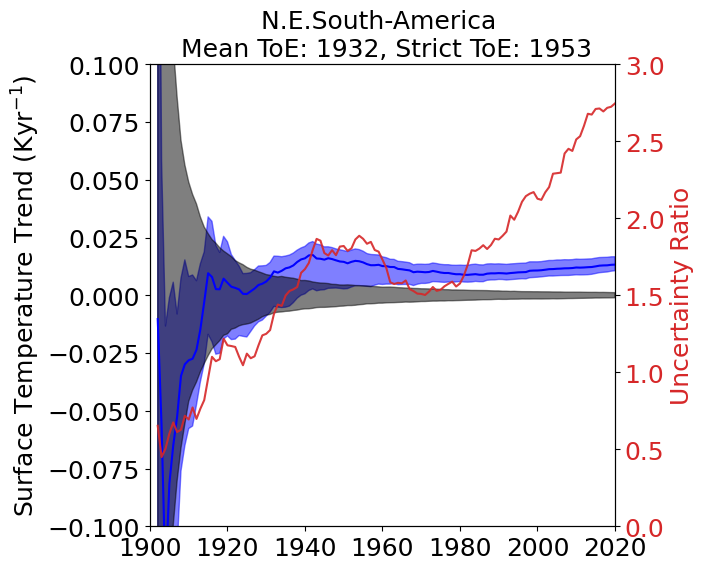

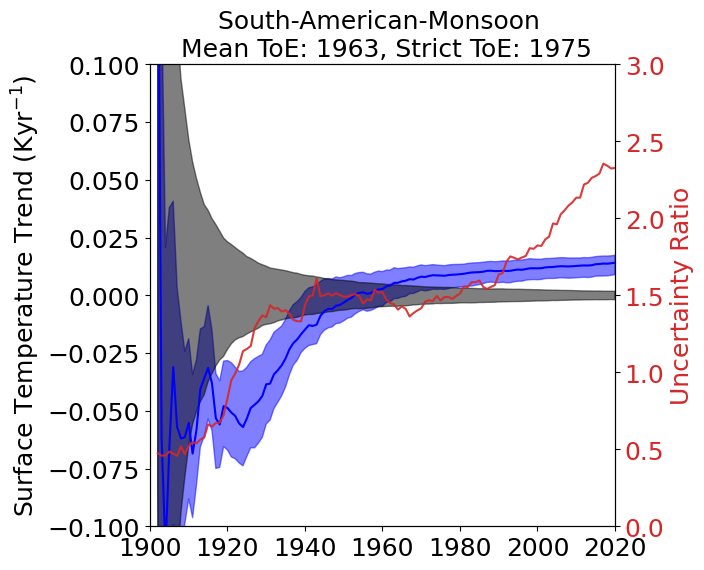

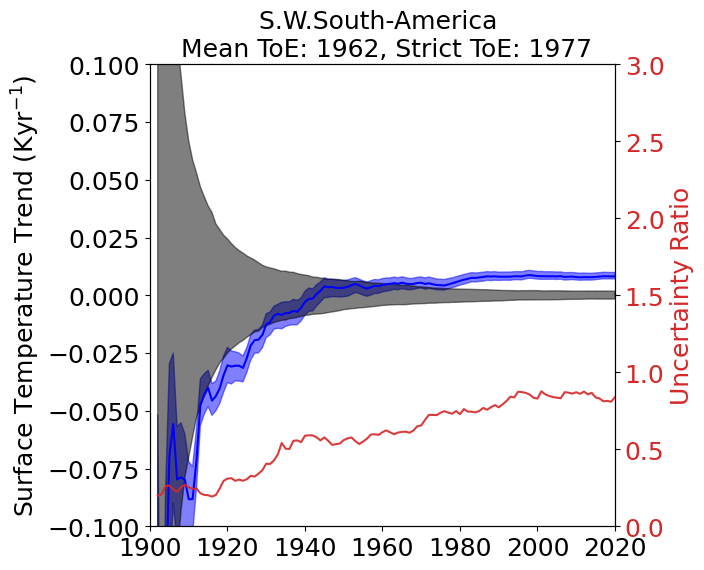

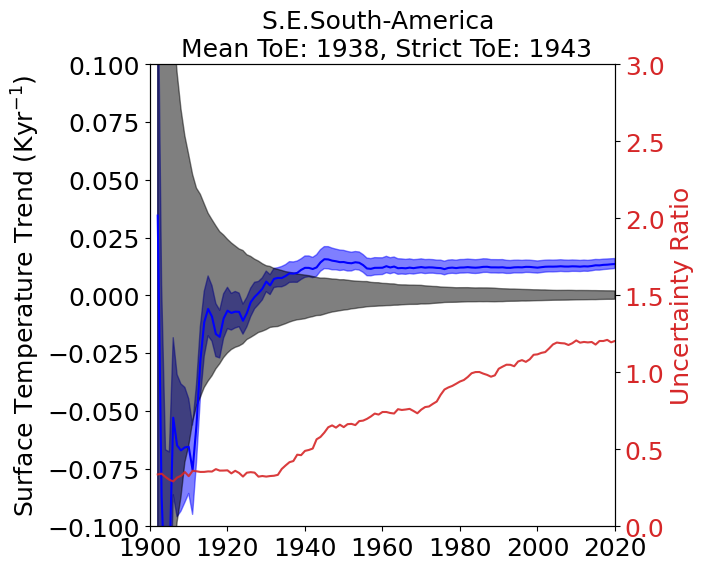

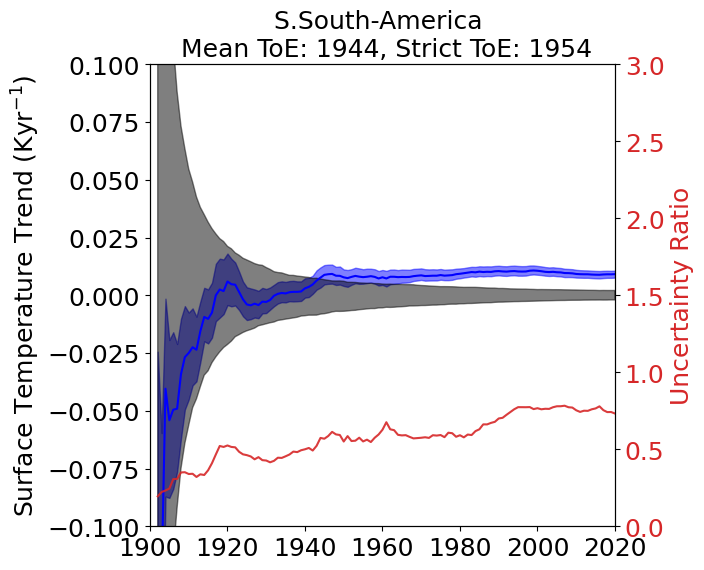

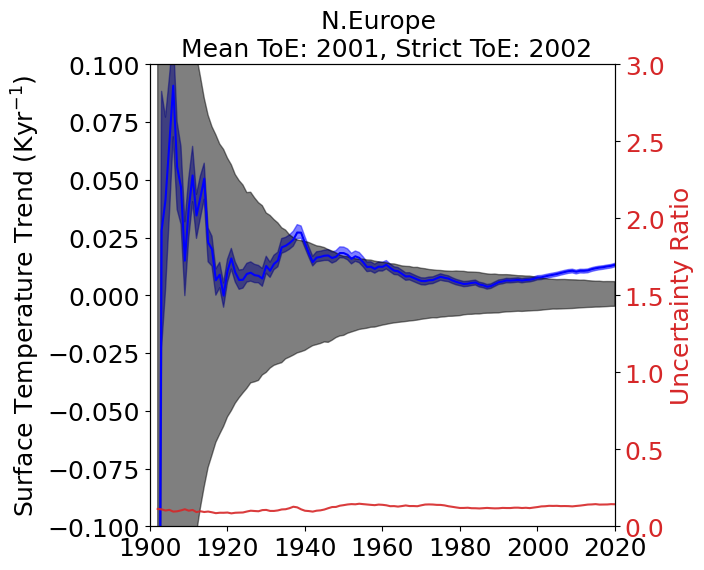

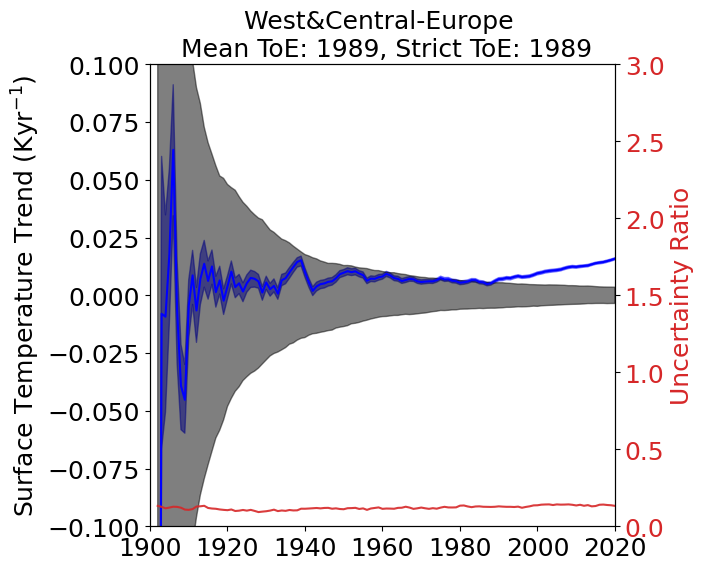

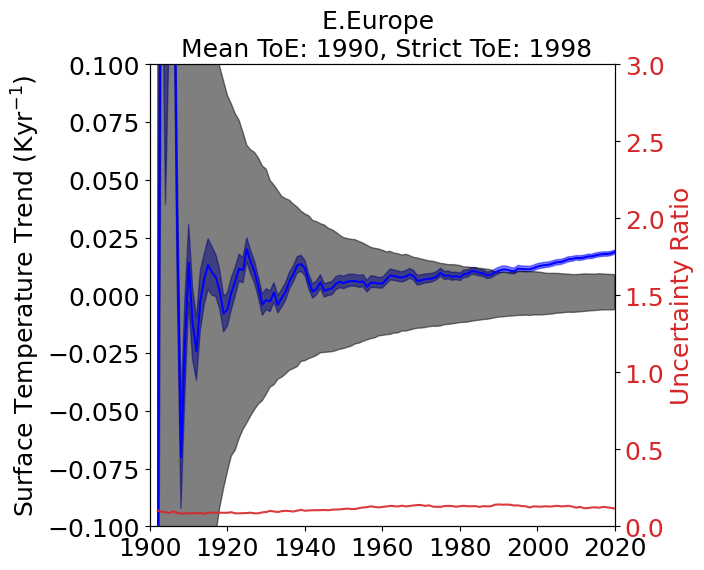

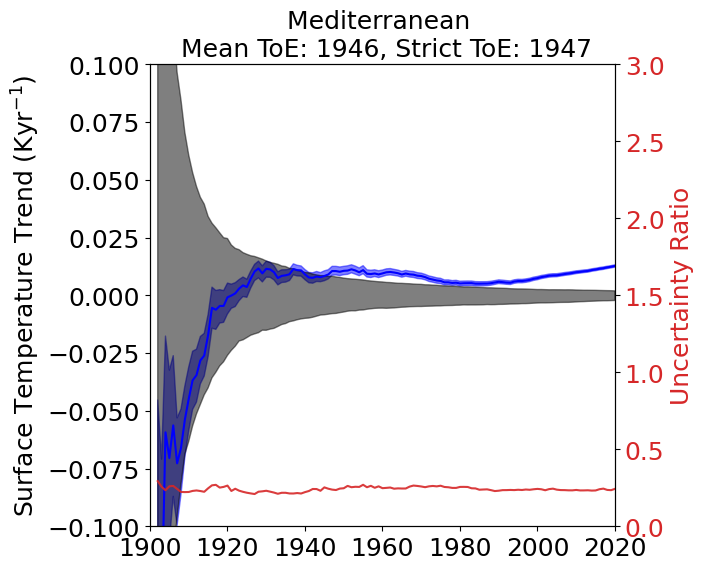

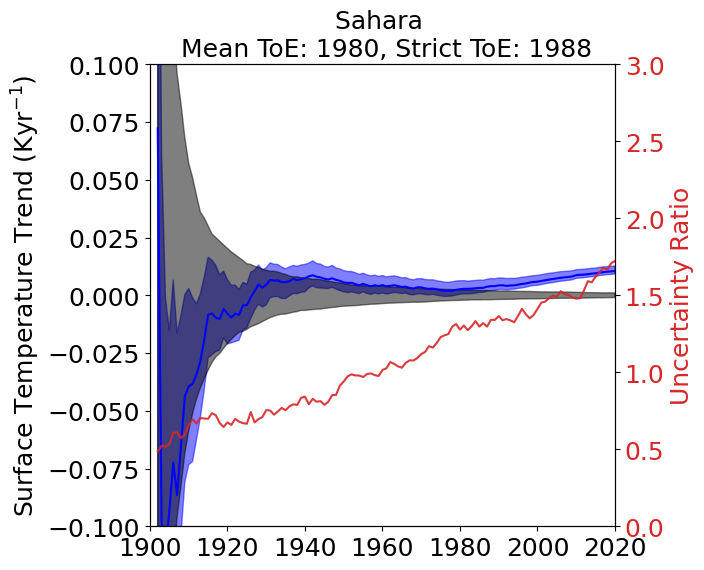

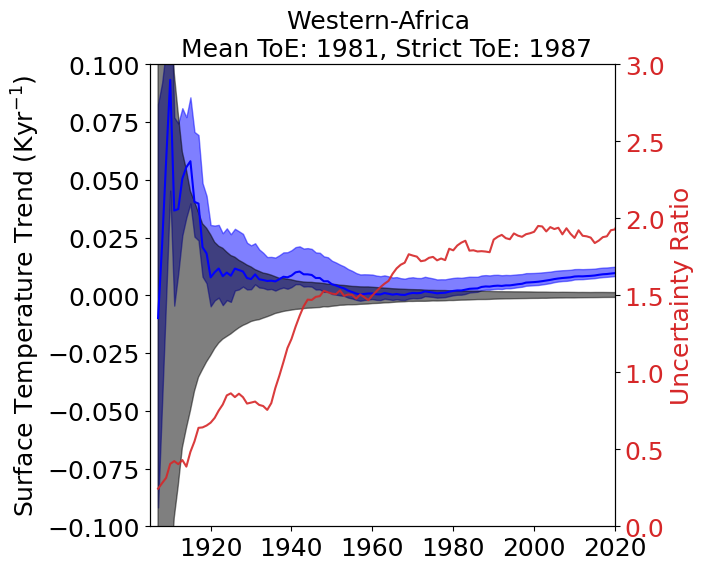

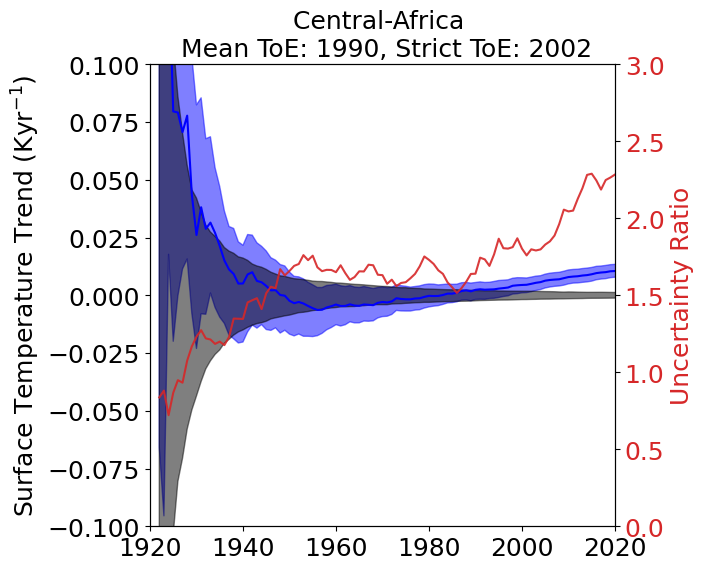

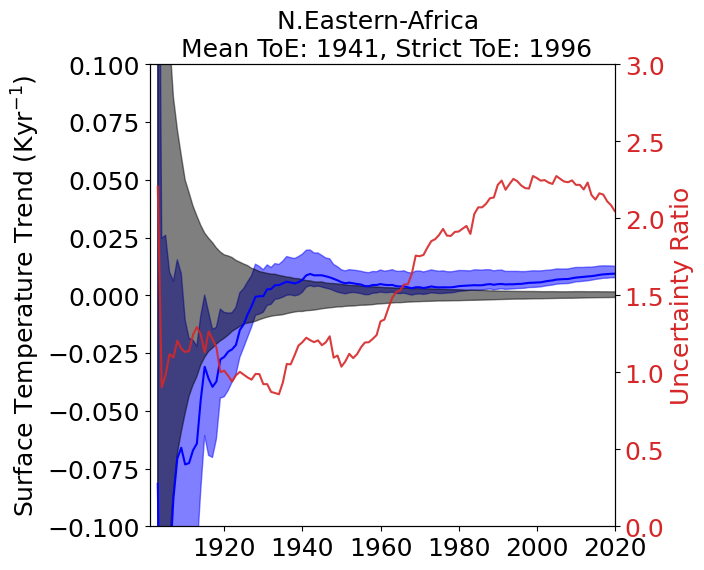

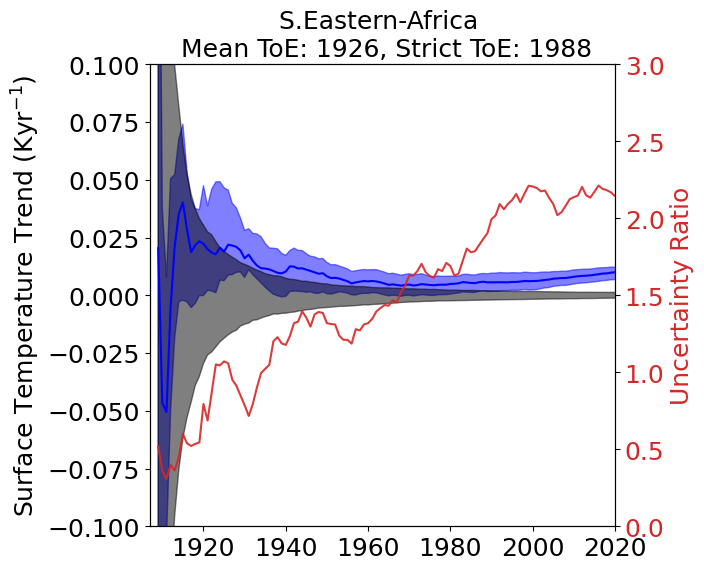

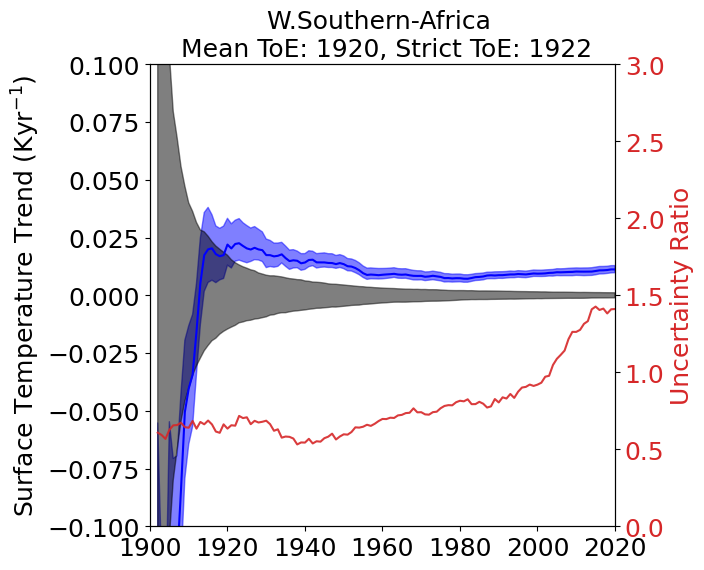

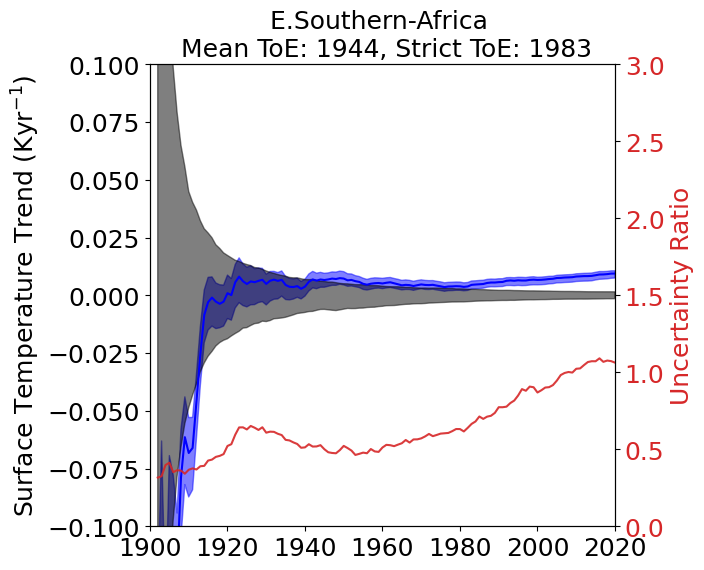

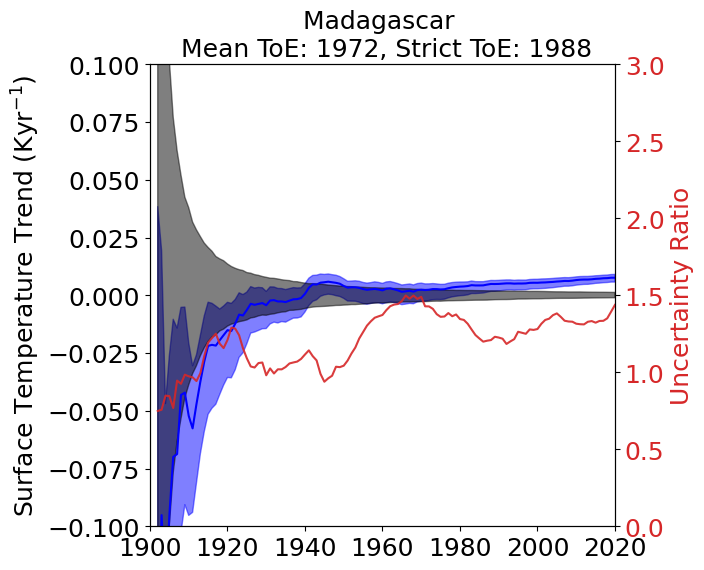

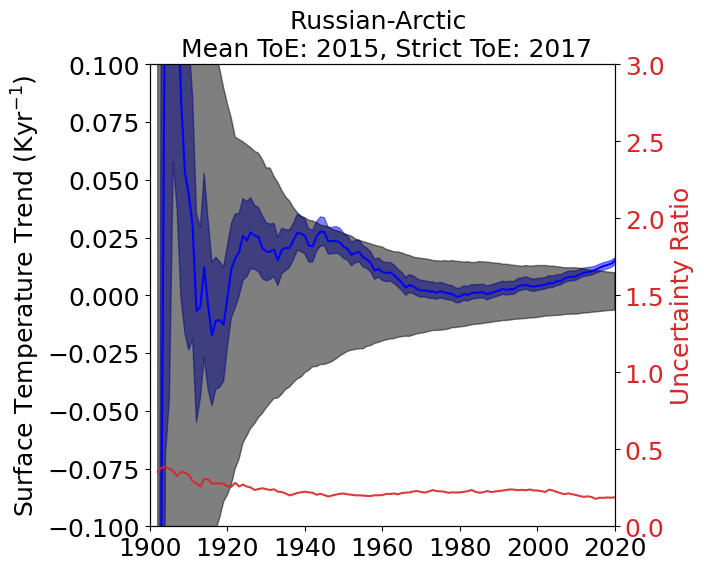

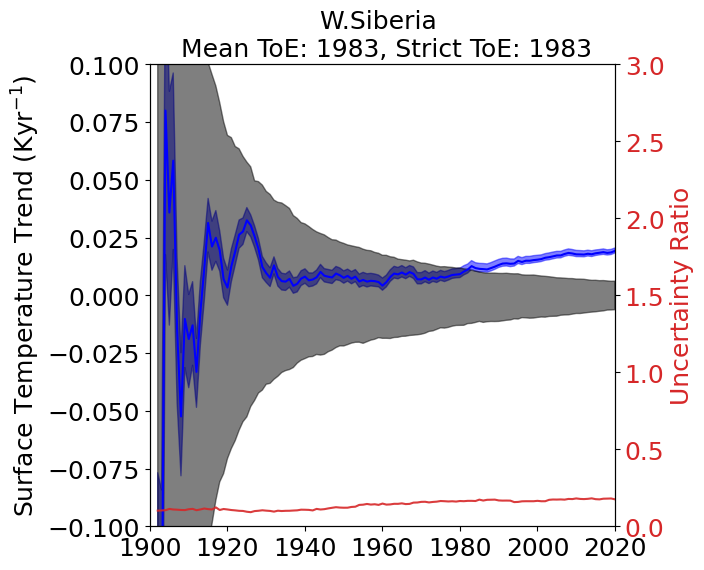

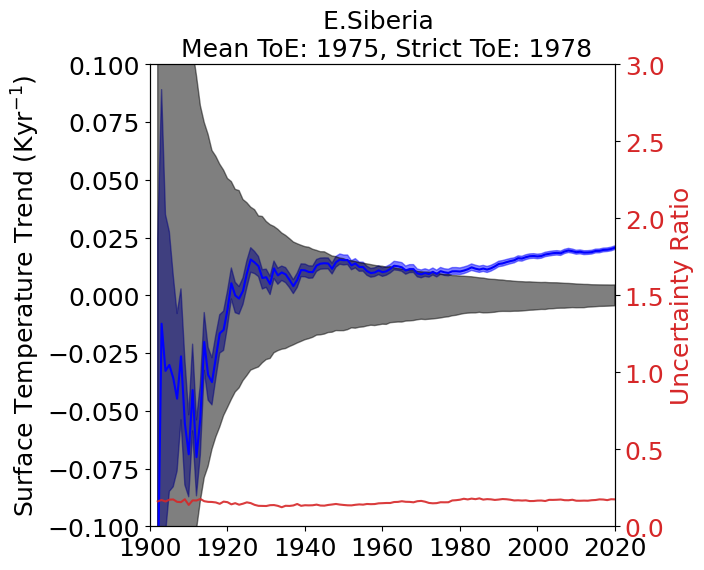

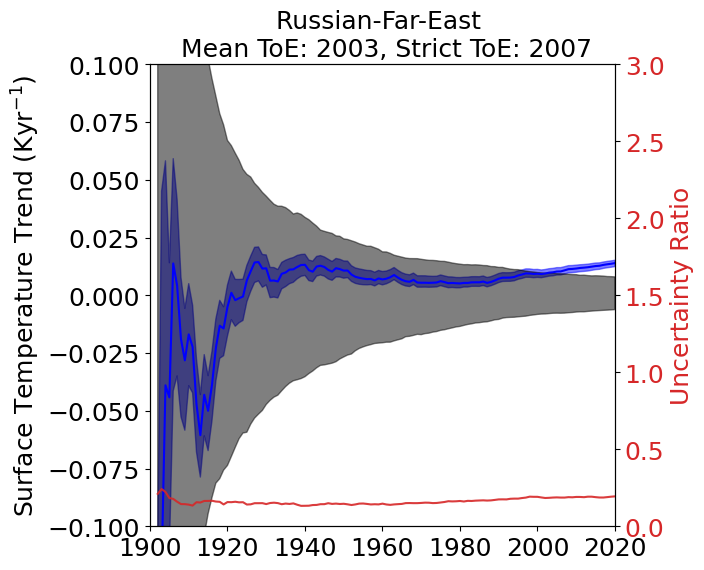

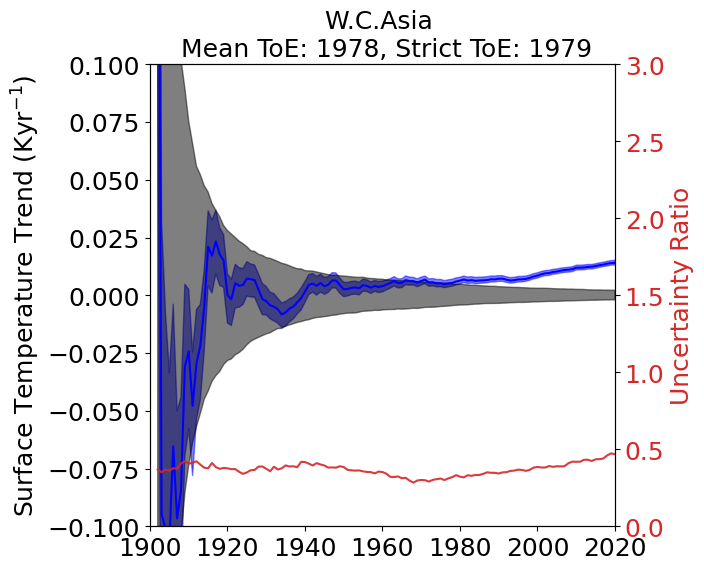

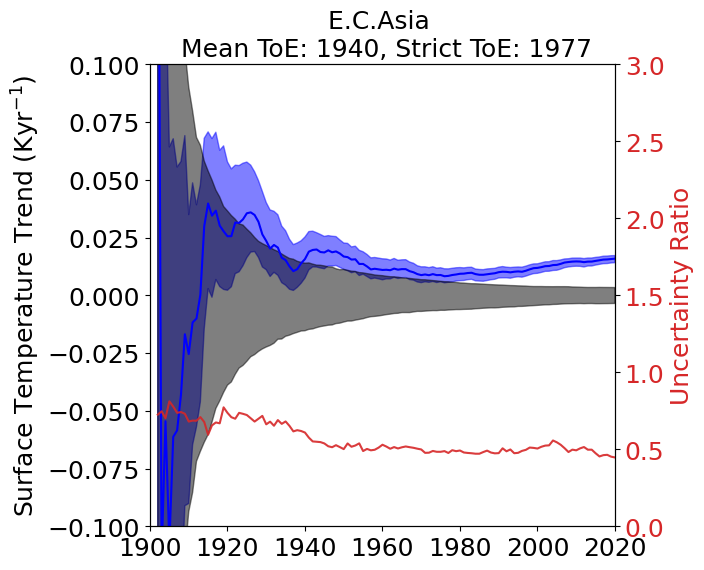

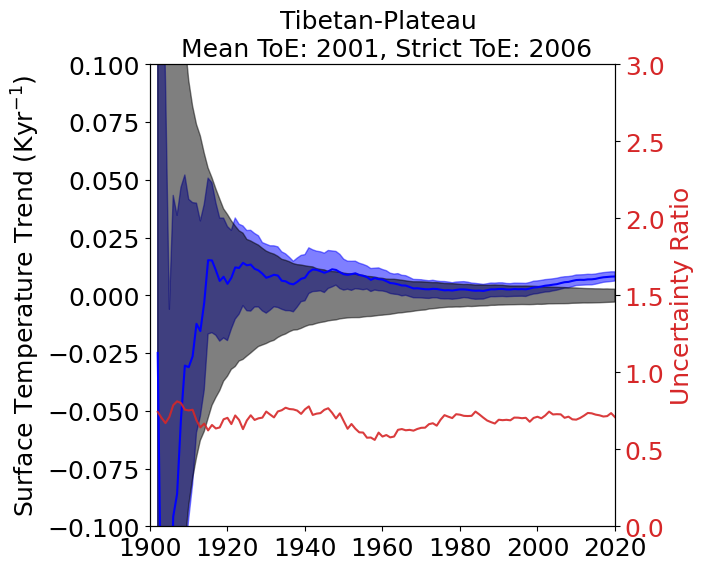

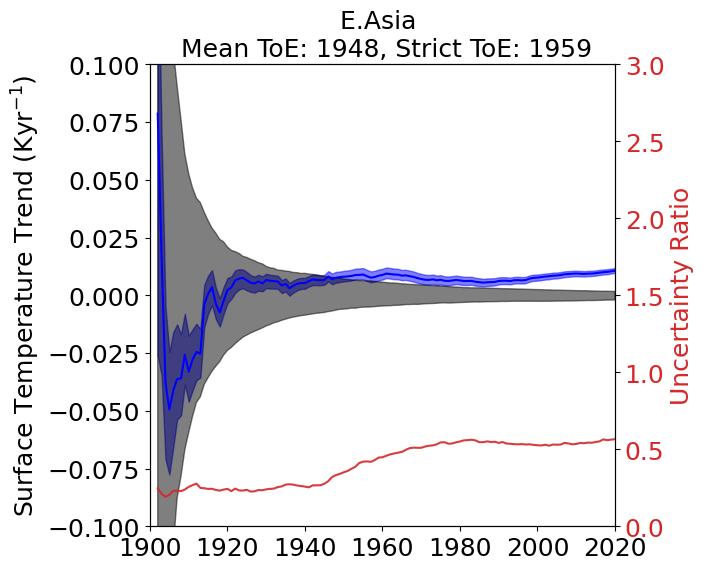

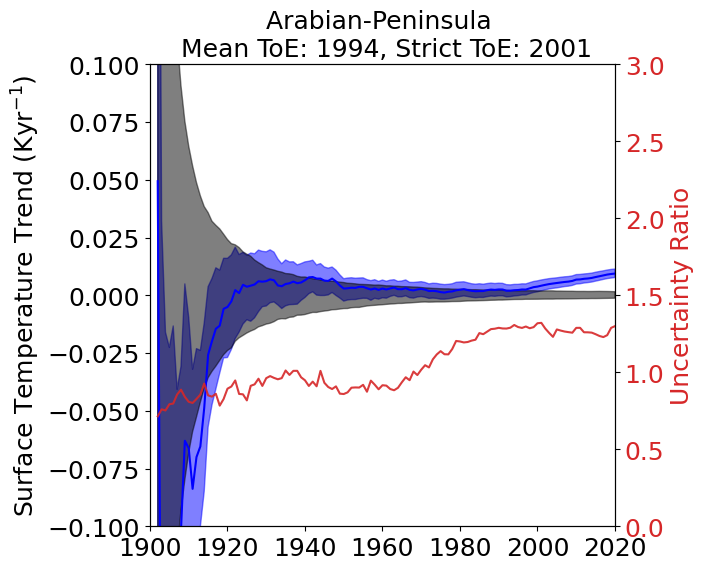

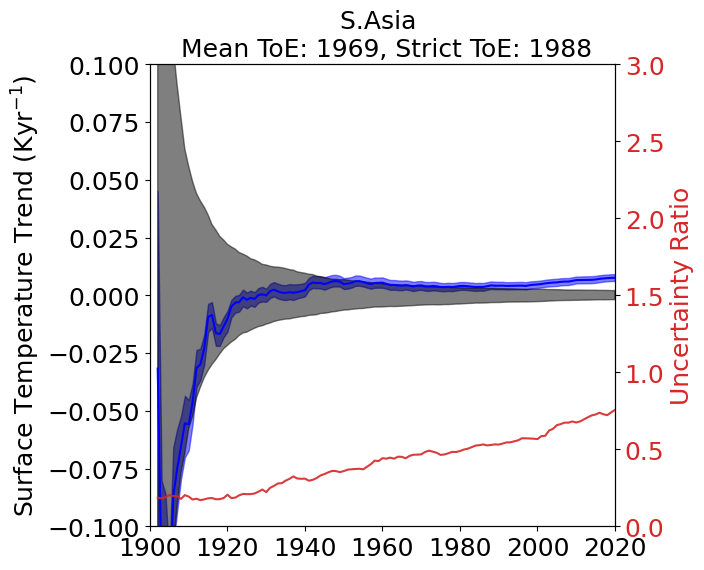

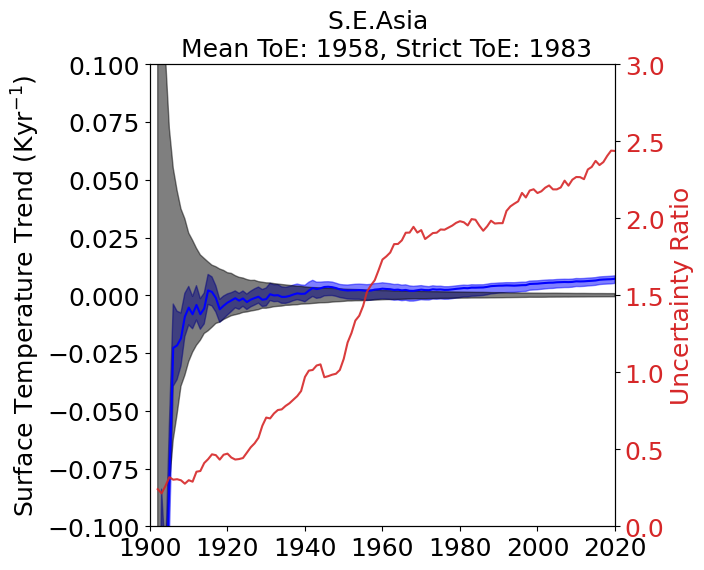

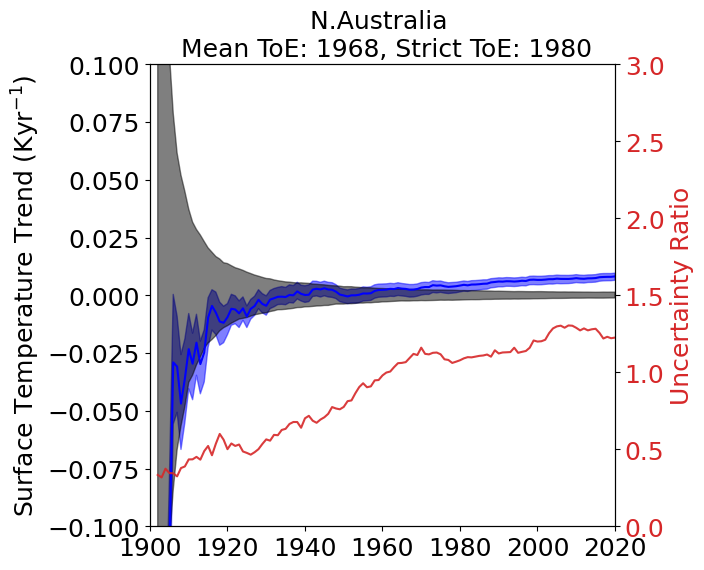

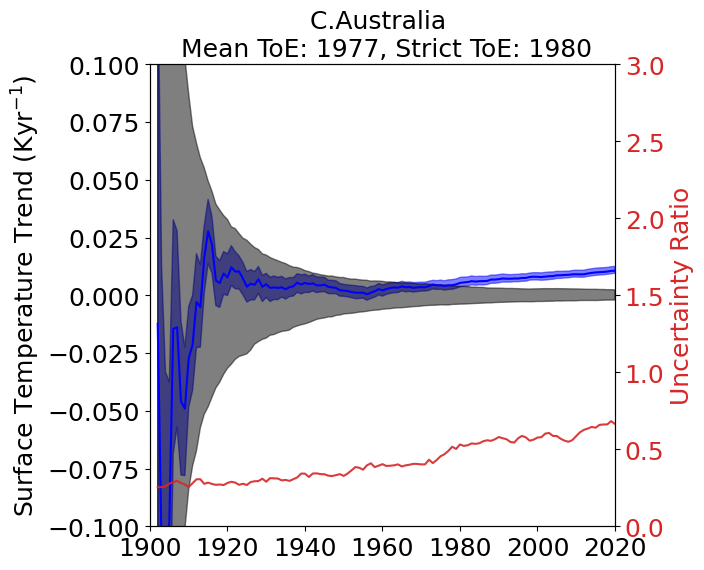

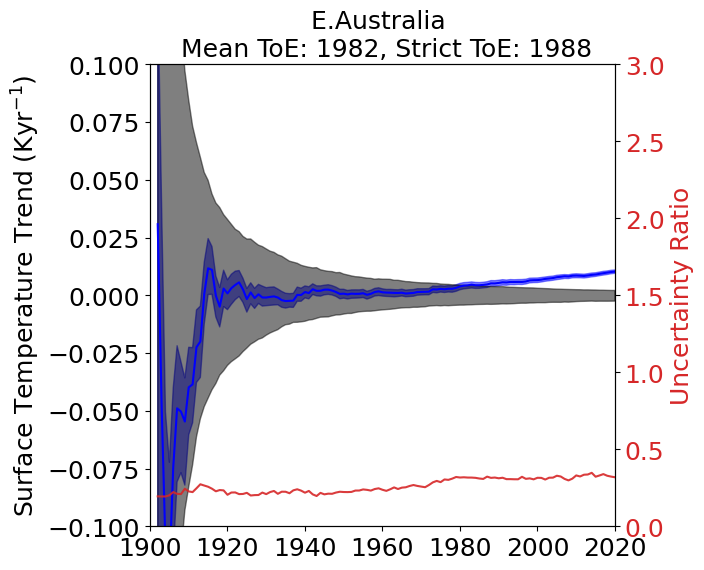

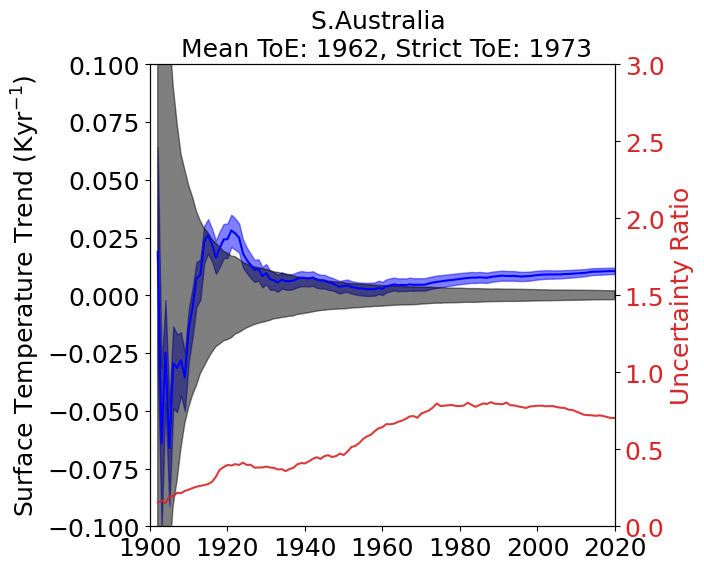

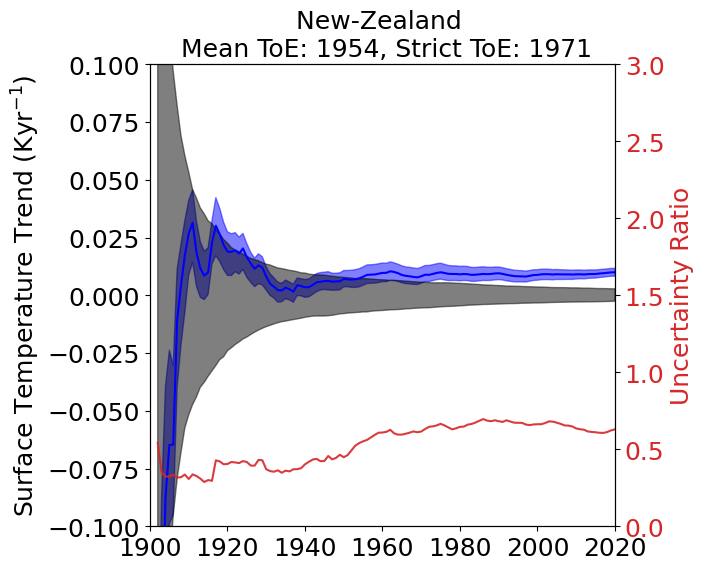

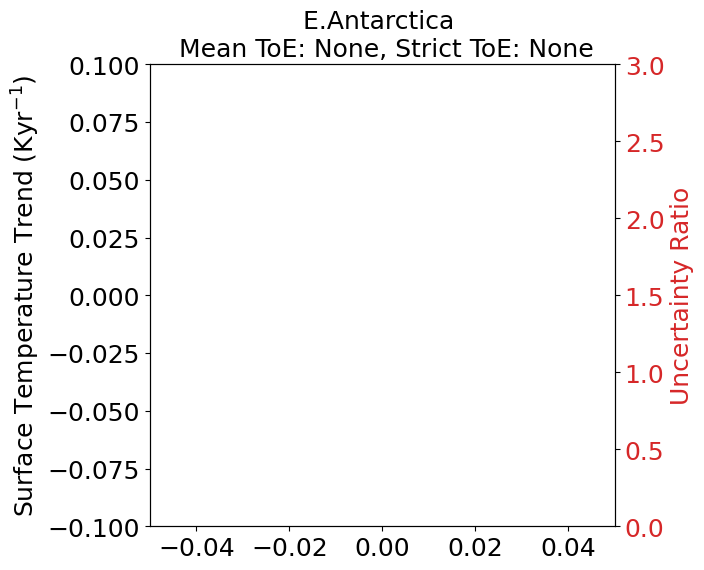

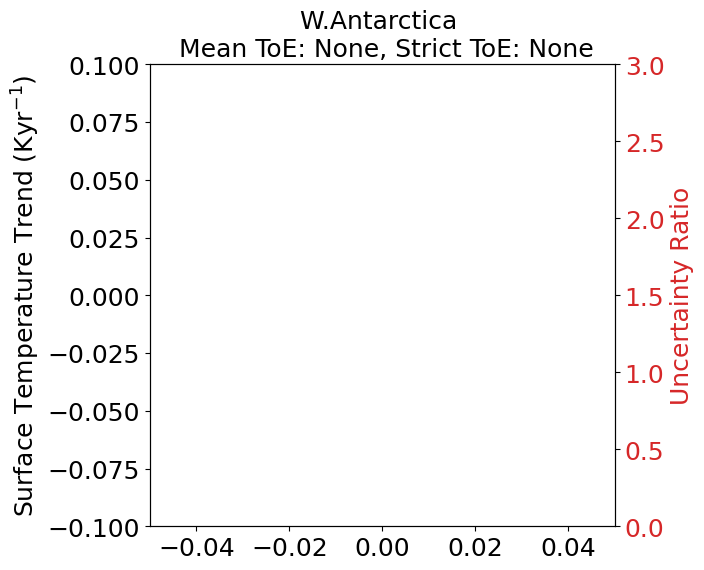

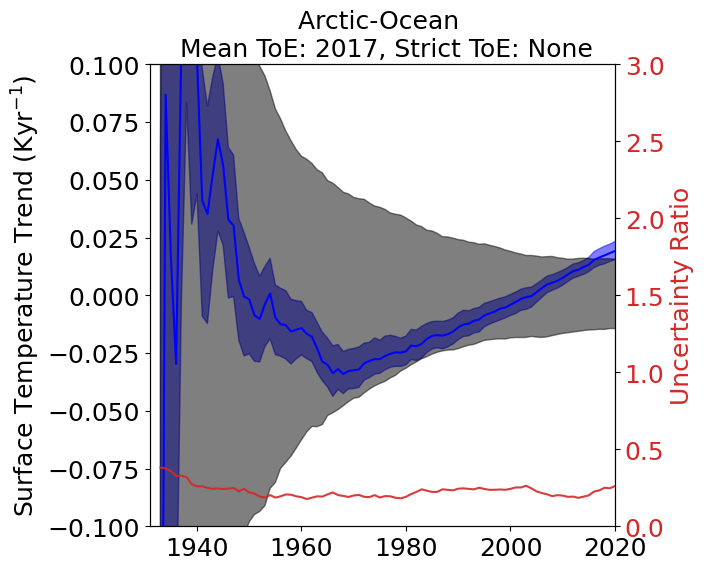

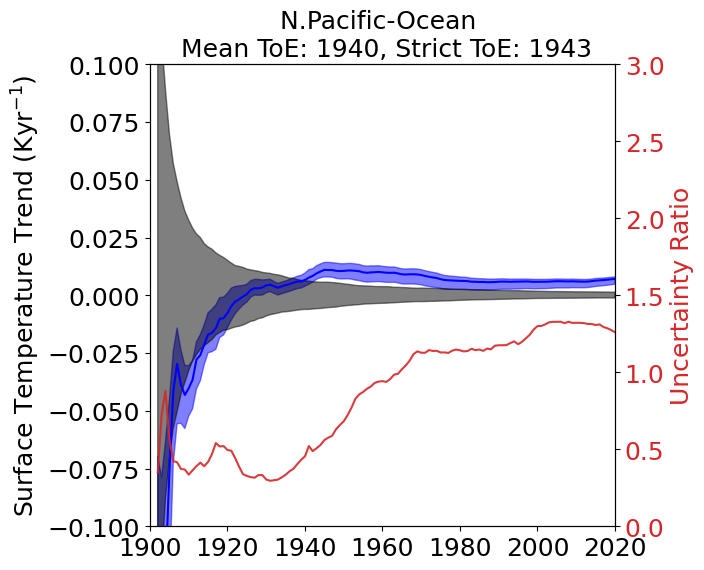

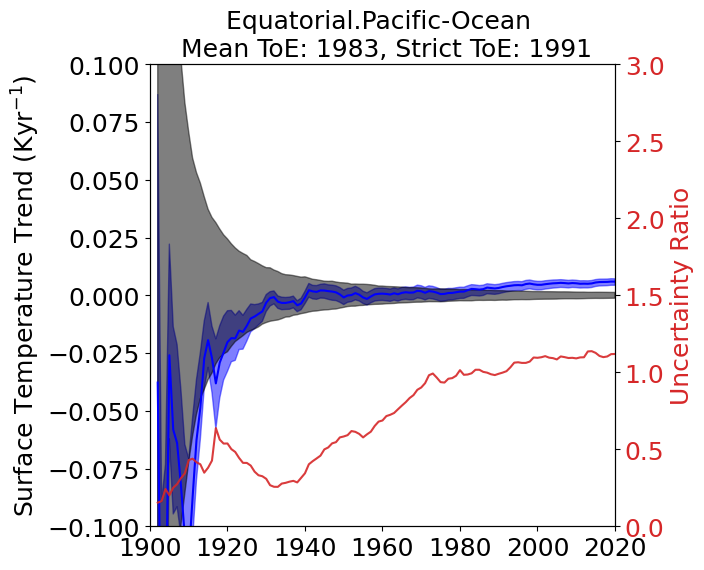

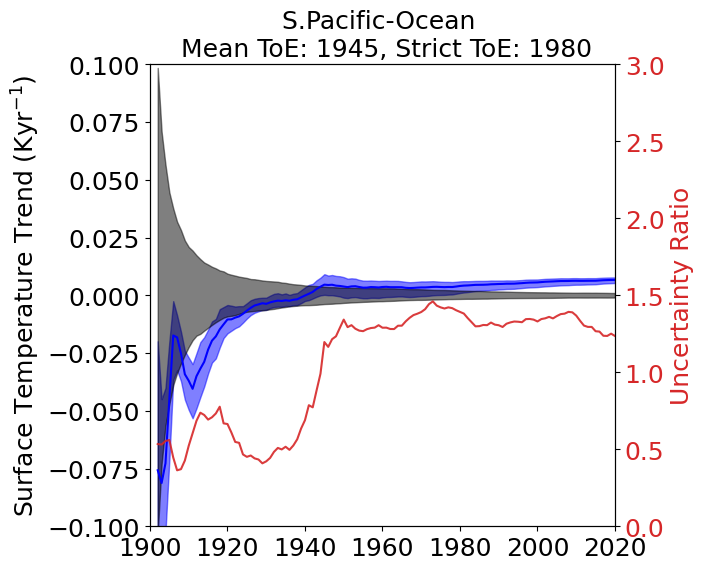

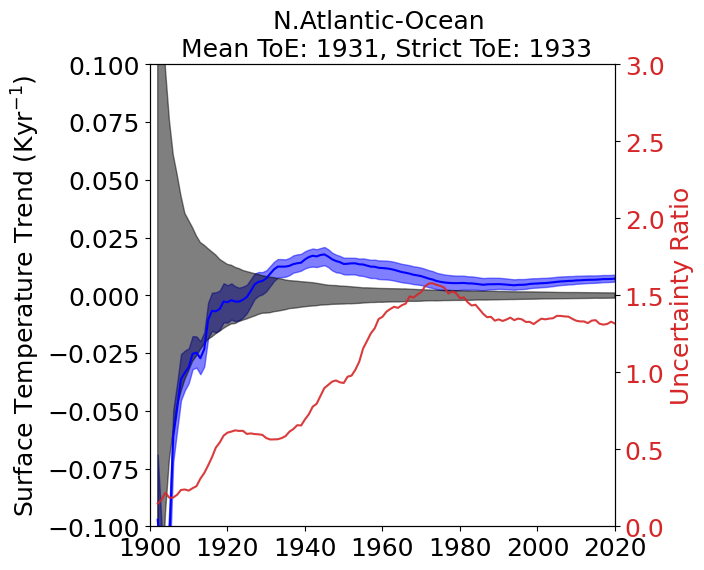

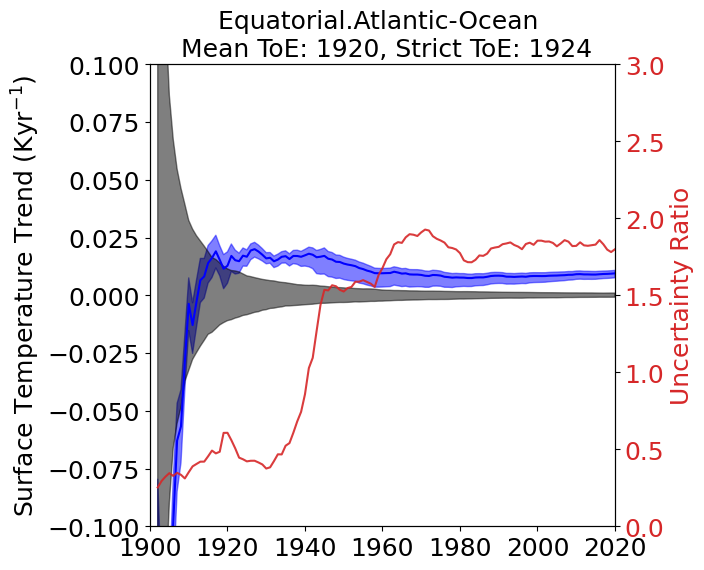

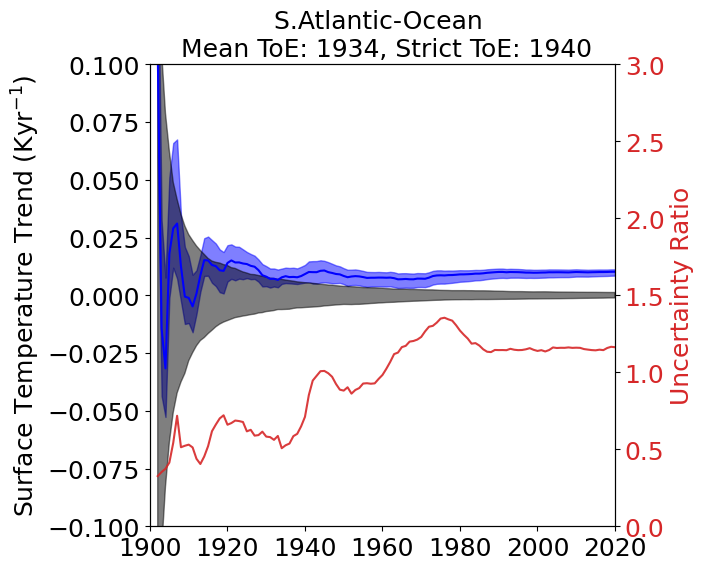

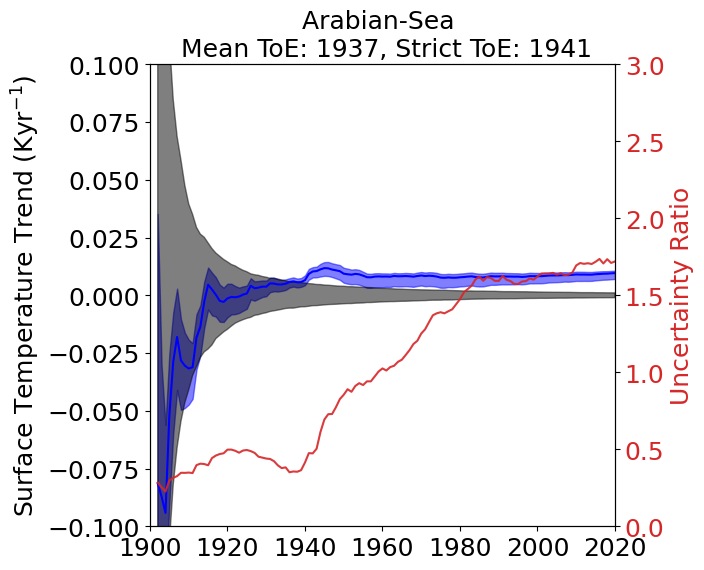

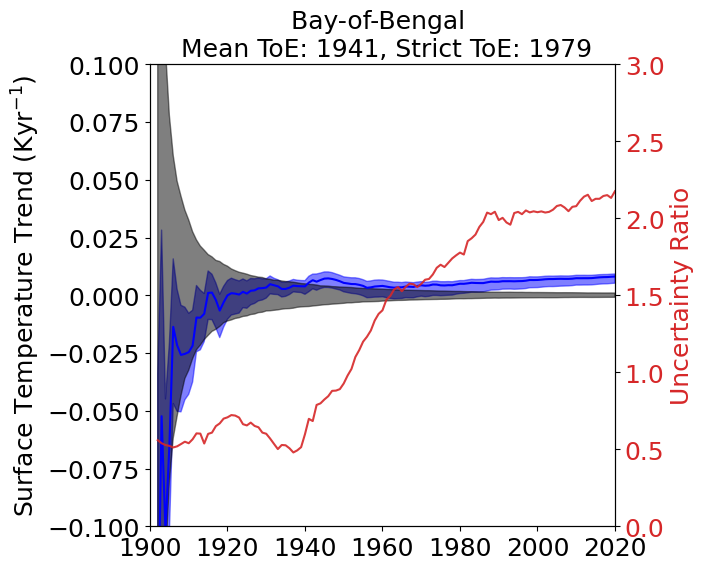

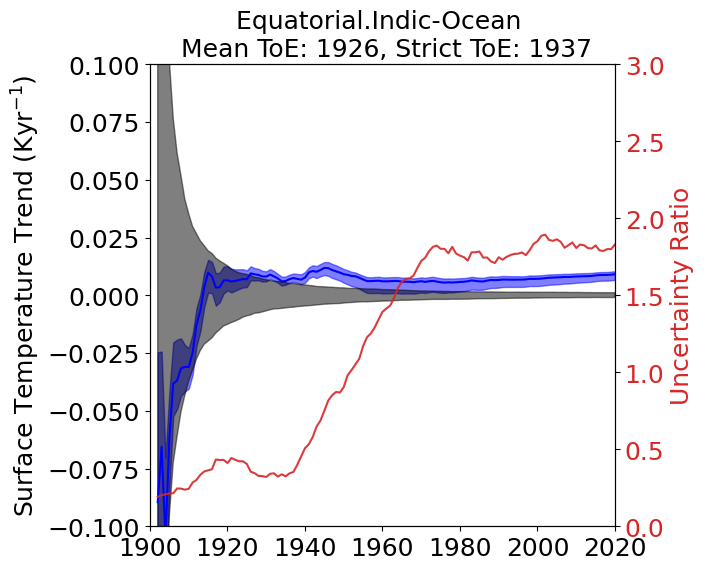

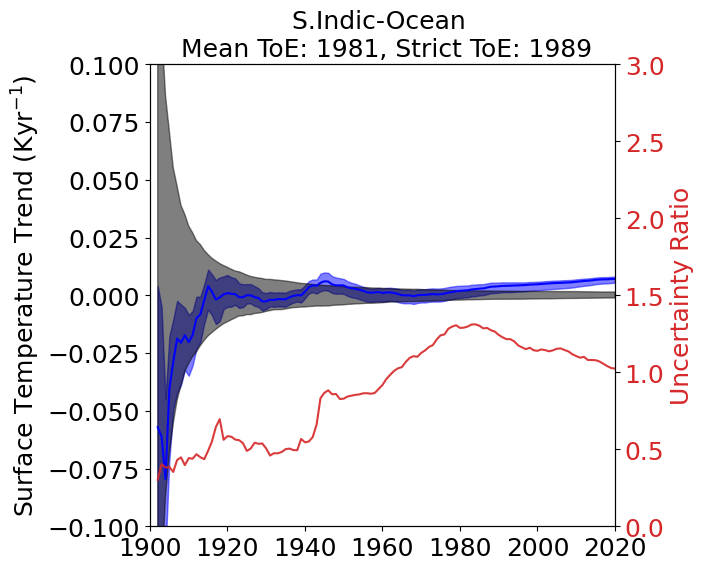

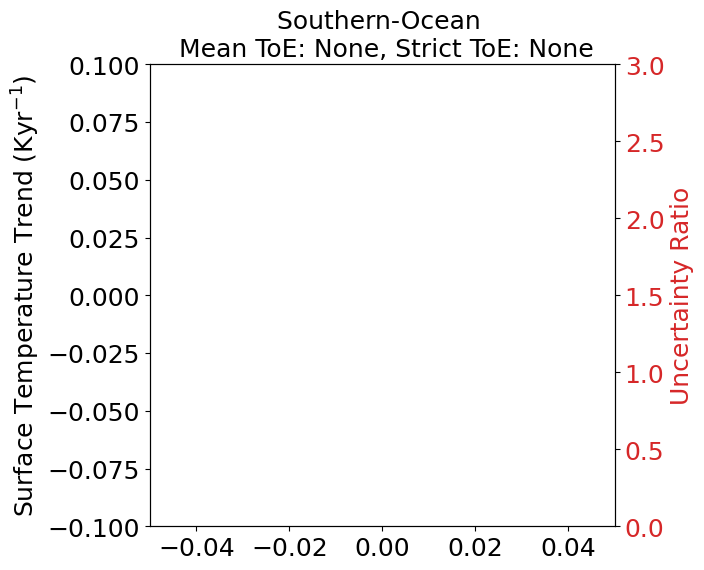

In [81]:
# startyear = 1900

obs_percentile_data   = gistemp_regional_trendpercs_all #gistemp_regional_trendpercs_all # hadcrut5_regional_trendpercs_all
obs_startyear_data    = gistemp_regional_startyears
model_percentile_data = cesm1_pic_regional_trends_all

year_gistemp = startyear + obs_percentile_data.duration - 1
year_cesm1   = startyear + model_percentile_data.duration - 1

for region_index in obs_percentile_data.RegionIndex:

    startyear = obs_startyear_data.sel(RegionIndex=region_index)
    year_gistemp = startyear + obs_percentile_data.duration - 1
    year_cesm1   = startyear + model_percentile_data.duration - 1

    # Compute the mean and strict ToEs
    _mean_tte        = mean_tte.sel(RegionIndex=region_index)
    _strict_tte      = strict_tte.sel(RegionIndex=region_index)
    _gistemp_cesm1_uncratio = gistemp_cesm1_uncratio.sel(RegionIndex=region_index)
    _obs_percentile_data = obs_percentile_data.sel(RegionIndex=region_index)
    _model_percentile_data = model_percentile_data.sel(RegionIndex=region_index)
    
    fig = create_coneplot(
        obs_percentiles=_obs_percentile_data,
        model_percentiles=_model_percentile_data,
        obs_times=year_gistemp,
        model_times=year_cesm1,
        mean_tte=_mean_tte,
        strict_tte=_strict_tte,
        uncertainty_ratio=_gistemp_cesm1_uncratio,
        startyear=startyear,
        ylim=[-0.1, 0.1],
        title=str(_mean_tte.RegionName.values)
    )
    # plt.show()
    # plt.close()
    # continue
    # break
    regionname = str(_mean_tte.RegionName.values).replace("/", "_")
    regionindex = str(_mean_tte.RegionIndex.values)
    _filename = f"coneplot3_Region{regionindex}_{regionname}"
        
    to_png(
        file=fig,
        filename=_filename,
        dpi=300,
        ext='pdf',
        bbox_inches='tight',
        loc='/glade/u/home/jonahshaw/figures/coneplots/'
    ) # or .pdf 
    plt.show()
    plt.close()